In [1]:
"""Load Matplotlib and data wrangling libraries"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [2]:
"""Import Data"""
df = pd.read_csv('ConstructionTimeSeriesDataV2.csv')
df.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


# Private Construction
## Import Data, Determine Moving Average and Remainder

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvgPrivate,R1Private
6,7,Jul-02,78863,58494,20369,52878.250000,5615.750000
7,8,Aug-02,79460,57953,21507,52892.625000,5060.375000
8,9,Sep-02,76542,55157,21385,52923.666667,2233.333333
9,10,Oct-02,75710,56023,19687,52945.000000,3078.000000
10,11,Nov-02,71362,53552,17810,52994.541667,557.458333


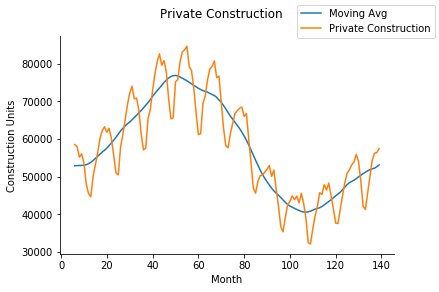

In [3]:
"""Import Data"""
df = pd.read_csv('ConstructionTimeSeriesDataV2.csv')
df.head()

df['MovAvgPrivate'] = np.NaN  # Creates an empty column for the Moving Average component data
df['R1Private'] = np.NaN  # Creates an empty column for the Remainder component data

window = 12  # selected by best fit
window = window - window % 2
# Compute the moving average in the loop below using a window centered on the data point whose average is being computed
for i in range(int(window/2),df.shape[0]-int(window/2)):
    df.loc[df.index[i],'MovAvgPrivate'] = (0.5*df.iloc[i - int(window/2)]['Private Construction'] + df.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum() + 0.5*df.iloc[i + int(window/2)]['Private Construction'])/float(window)

# Calculate the error
df['R1Private'] = df['Private Construction'] - df['MovAvgPrivate']

# The moving average cannot be applied to all rows and we need to delete those rows because we cannot use them in the analysis
df.dropna(how='any',inplace=True)

# Review Data 
fig,ax = plt.subplots()
ax.plot(df['MovAvgPrivate'], label='Moving Avg')
ax.plot(df['Private Construction'], label='Private Construction')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Units')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
fig.suptitle("Private Construction")
df.head()

## Determine Repeating Average

period =  12      Maximum Correlation =  0.9718794492320808


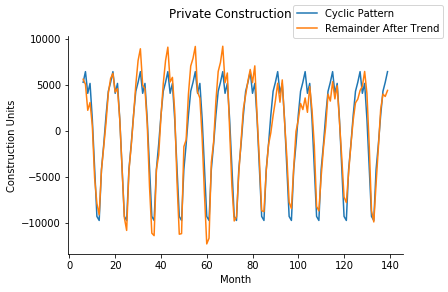

In [4]:
# Calculate the repeating pattern using autocorrelation
# Determine lag for greatest possible correlation
maxCorr = 0.0
period = np.NaN
for i in range(1,len(df) - 1):
    corr = df['R1Private'].autocorr(lag=i)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

#Computes an average for each of the points within the cycle over all intances of each point in the data
cycleLen = period
numCycles = int(len(df)/cycleLen + 0.5)
cycles = [df.iloc[range(i*period,min((i+1)*period,len(df)))]['R1Private'] for i in range(numCycles)]
ptsInCycles = [df.iloc[range(i,len(df['R1Private']),period)]['R1Private'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

# Determine Cyclicality and review Data
cycleLen = period   
numCycles = int(len(df)/cycleLen + 0.5)
df['CPrivate'] = np.NaN   # Creates an empty column for the cyclicality component data
for i in range(len(df)):
    df.loc[df.index[i], 'CPrivate'] = avg[i % cycleLen] # Write appropriate cyclicality value



fig,ax = plt.subplots()
ax.plot(df['CPrivate'],label='Cyclic Pattern')
ax.plot(df['R1Private'],label='Remainder After Trend')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Units')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle("Private Construction")
fig.legend()



## Determine R2 and R2 Error

Cumulative Private squarred error:  0.08961945768698265


,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvgPrivate,CPrivate,R2Private,R2ErrorPrivate,fitPrivate,SqErrorPrivate
6,7,Jul-02,78863,58494,20369,52878.250000,5281.409722,334.340278,0.005716,58159.659722,0.000033
7,8,Aug-02,79460,57953,21507,52892.625000,6441.833333,-1381.458333,0.023838,59334.458333,0.000568
8,9,Sep-02,76542,55157,21385,52923.666667,4081.571970,-1848.238636,0.033509,57005.238636,0.001123
9,10,Oct-02,75710,56023,19687,52945.000000,5159.443182,-2081.443182,0.037153,58104.443182,0.001380
10,11,Nov-02,71362,53552,17810,52994.541667,1250.583333,-693.125000,0.012943,54245.125000,0.000168


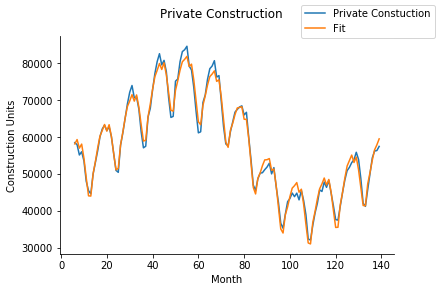

In [5]:
# Determine R2 and R2 Error
df['R2Private'] = np.NaN # Initialize
df['R2Private'] = df['R1Private'] - df['CPrivate']
df['R2ErrorPrivate'] = np.NaN # Initialize
df['R2ErrorPrivate'] = abs(df['R2Private']/df['Private Construction'])

# Determine fit 
df['fitPrivate'] = np.NaN # Initialize
df['fitPrivate'] = df['MovAvgPrivate'] + df['CPrivate']

# Determine Squared Fit Error
df['SqErrorPrivate'] = np.NaN # Initialize
df['SqErrorPrivate'] = (df['R2ErrorPrivate']**2)
print('Cumulative Private squarred error: ', sum(df['SqErrorPrivate']))

# Drop uneeded rows
df.drop(['R1Private'],axis=1,inplace=True)

fig,ax = plt.subplots()
ax.plot(df['Private Construction'],label='Private Constuction')
ax.plot(df['fitPrivate'], label = 'Fit')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Units')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle("Private Construction")
fig.legend()
   
df.head()


# Public Construction
## Determine Moving Average and Remainder

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvgPrivate,CPrivate,R2Private,R2ErrorPrivate,fitPrivate,SqErrorPrivate,MovAvgPublic,R1Public
12,13,Jan-03,59877,45473,14404,53392.416667,-9320.060606,1400.643939,0.030802,44072.356061,0.000949,17888.666667,-3484.666667
13,14,Feb-03,58526,44620,13906,53767.541667,-9760.712121,613.170455,0.013742,44006.829545,0.000189,17923.500000,-4017.500000
14,15,Mar-03,64506,49996,14510,54263.000000,-4203.363636,-63.636364,0.001273,50059.636364,0.000002,17971.000000,-3461.000000
15,16,Apr-03,69638,53195,16444,54821.333333,-1459.571970,-166.761364,0.003135,53361.761364,0.000010,18026.166667,-1582.166667
16,17,May-03,74473,56286,18187,55377.708333,1697.541667,-789.250000,0.014022,57075.250000,0.000197,18052.208333,134.791667


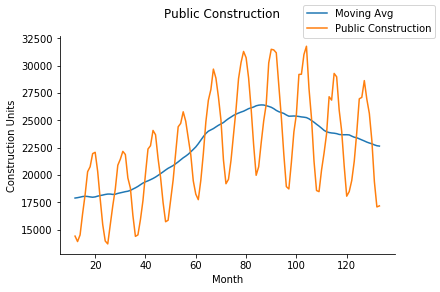

In [6]:
df['MovAvgPublic'] = np.NaN  # Creates an empty column for the Moving Average component data
df['R1Public'] = np.NaN  # Creates an empty column for the Remainder component data

window = 12  # selected by best fit
window = window - window % 2
# Compute the moving average in the loop below using a window centered on the data point whose average is being computed
for i in range(int(window/2),df.shape[0]-int(window/2)):
    df.loc[df.index[i],'MovAvgPublic'] = (0.5*df.iloc[i - int(window/2)]['Public Construction'] + df.iloc[i - int(window/2)+1:i + int(window/2)]['Public Construction'].sum() + 0.5*df.iloc[i + int(window/2)]['Public Construction'])/float(window)

# Calculate the error
df['R1Public'] = df['Public Construction'] - df['MovAvgPublic']

# The moving average cannot be applied to all rows and we need to delete those rows because we cannot use them in the analysis
df.dropna(how='any',inplace=True)

# Review Data 
fig,ax = plt.subplots()
ax.plot(df['MovAvgPublic'], label='Moving Avg')
ax.plot(df['Public Construction'], label='Public Construction')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Units')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
fig.suptitle("Public Construction")
df.head()


## Determine Repeating Average

period =  108      Maximum Correlation =  0.9892212336430922


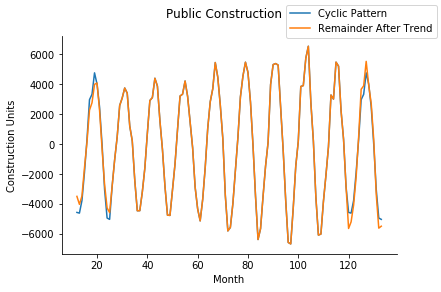

In [7]:
# Calculate the repeating pattern using autocorrelation
# Determine lag for greatest possible correlation
maxCorr = 0.0
period = np.NaN
for i in range(1,len(df) - 1):
    corr = df['R1Public'].autocorr(lag=i)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

#Computes an average for each of the points within the cycle over all intances of each point in the data
cycleLen = period
numCycles = int(len(df)/cycleLen + 0.5)
cycles = [df.iloc[range(i*period,min((i+1)*period,len(df)))]['R1Public'] for i in range(numCycles)]
ptsInCycles = [df.iloc[range(i,len(df['R1Public']),period)]['R1Public'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

# Determine Cyclicality and review Data
cycleLen = period   
numCycles = int(len(df)/cycleLen + 0.5)
df['CPublic'] = np.NaN   # Creates an empty column for the cyclicality component data
for i in range(len(df)):
    df.loc[df.index[i], 'CPublic'] = avg[i % cycleLen] # Write appropriate cyclicality value



fig,ax = plt.subplots()
ax.plot(df['CPublic'],label='Cyclic Pattern')
ax.plot(df['R1Public'],label='Remainder After Trend')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Units')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle("Public Construction")
fig.legend()



## Determine R2 and R2 Error

Cumulative Public squarred error:  0.025284150328570645


,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvgPrivate,CPrivate,R2Private,R2ErrorPrivate,fitPrivate,SqErrorPrivate,MovAvgPublic,CPublic,R2Public,R2ErrorPublic,fitPublic,SqErrorPublic
12,13,Jan-03,59877,45473,14404,53392.416667,-9320.060606,1400.643939,0.030802,44072.356061,0.000949,17888.666667,-4555.770833,1071.104167,0.074362,13332.895833,0.005530
13,14,Feb-03,58526,44620,13906,53767.541667,-9760.712121,613.170455,0.013742,44006.829545,0.000189,17923.500000,-4601.687500,584.187500,0.042010,13321.812500,0.001765
14,15,Mar-03,64506,49996,14510,54263.000000,-4203.363636,-63.636364,0.001273,50059.636364,0.000002,17971.000000,-3763.000000,302.000000,0.020813,14208.000000,0.000433
15,16,Apr-03,69638,53195,16444,54821.333333,-1459.571970,-166.761364,0.003135,53361.761364,0.000010,18026.166667,-1890.062500,307.895833,0.018724,16136.104167,0.000351
16,17,May-03,74473,56286,18187,55377.708333,1697.541667,-789.250000,0.014022,57075.250000,0.000197,18052.208333,312.729167,-177.937500,0.009784,18364.937500,0.000096


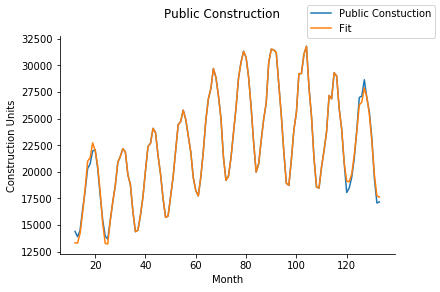

In [8]:
# Determine R2 and R2 Error
df['R2Public'] = np.NaN # Initialize
df['R2Public'] = df['R1Public'] - df['CPublic']
df['R2ErrorPublic'] = np.NaN # Initialize
df['R2ErrorPublic'] = abs(df['R2Public']/df['Public Construction'])

# Determine fit 
df['fitPublic'] = np.NaN # Initialize
df['fitPublic'] = df['MovAvgPublic'] + df['CPublic']

# Determine Squared Fit Error
df['SqErrorPublic'] = np.NaN # Initialize
df['SqErrorPublic'] = (df['R2ErrorPublic']**2)
print('Cumulative Public squarred error: ', sum(df['SqErrorPublic']))

# Drop uneeded rows
df.drop(['R1Public'],axis=1,inplace=True)

fig,ax = plt.subplots()
ax.plot(df['Public Construction'],label='Public Constuction')
ax.plot(df['fitPublic'], label = 'Fit')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Units')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle("Public Construction")
fig.legend()
   
df.head()


# Clean up Tabular Data and Plot Models

Cumulative Private squarred error:  0.08260132722108106
Cumulative Public squarred error:  0.025284150328570645


,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvgPrivate,CPrivate,R2Private,R2ErrorPrivate,fitPrivate,SqErrorPrivate,MovAvgPublic,CPublic,R2Public,R2ErrorPublic,fitPublic,SqErrorPublic
12,13,Jan-03,59877,45473,14404,53392.416667,-9320.060606,1400.643939,0.030802,44072.356061,0.000949,17888.666667,-4555.770833,1071.104167,0.074362,13332.895833,0.005530
13,14,Feb-03,58526,44620,13906,53767.541667,-9760.712121,613.170455,0.013742,44006.829545,0.000189,17923.500000,-4601.687500,584.187500,0.042010,13321.812500,0.001765
14,15,Mar-03,64506,49996,14510,54263.000000,-4203.363636,-63.636364,0.001273,50059.636364,0.000002,17971.000000,-3763.000000,302.000000,0.020813,14208.000000,0.000433
15,16,Apr-03,69638,53195,16444,54821.333333,-1459.571970,-166.761364,0.003135,53361.761364,0.000010,18026.166667,-1890.062500,307.895833,0.018724,16136.104167,0.000351
16,17,May-03,74473,56286,18187,55377.708333,1697.541667,-789.250000,0.014022,57075.250000,0.000197,18052.208333,312.729167,-177.937500,0.009784,18364.937500,0.000096


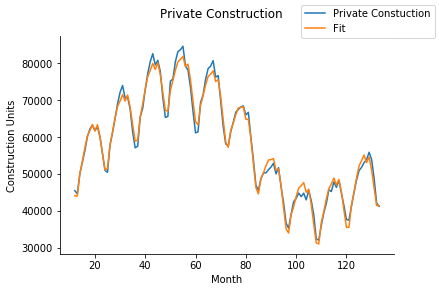

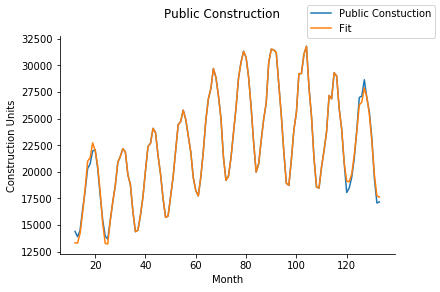

In [9]:

fig,ax = plt.subplots()
ax.plot(df['Private Construction'],label='Private Constuction')
ax.plot(df['fitPrivate'], label = 'Fit')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Units')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle("Private Construction")
fig.legend()
print('Cumulative Private squarred error: ', sum(df['SqErrorPrivate']))

fig,ax = plt.subplots()
ax.plot(df['Public Construction'],label='Public Constuction')
ax.plot(df['fitPublic'], label = 'Fit')
ax.set_xlabel('Month')
ax.set_ylabel('Construction Units')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle("Public Construction")
fig.legend()
print('Cumulative Public squarred error: ', sum(df['SqErrorPublic']))

df.head()